# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sqlite3
from statsmodels.tsa.seasonal import STL

# Classes

In [4]:
class SIRD:
    def __init__(self, s0, i0, r0, d0):
        self.ts = {
            'Susceptible': [s0],
            'Infected': [i0],
            'Recovered': [r0],
            'Deceased': [d0]
        }
        self.N = s0 + i0 + r0 + d0
        self.len = 1
    
    def step(self, alpha, beta, gamma, mu):
        s = self.ts['Susceptible'][-1]
        i = self.ts['Infected'][-1]
        r = self.ts['Recovered'][-1]
        d = self.ts['Deceased'][-1]

        a = alpha * r
        b = beta * s * i / self.N
        g = gamma * i
        m = mu * i

        self.ts['Susceptible'].append(s + a - b)
        self.ts['Infected'].append(i + b - m - g)
        self.ts['Recovered'].append(r + g - a)
        self.ts['Deceased'].append(d + m)
        self.len += 1

    def simulate(self, alpha, beta, gamma, mu):
        for a, b, g, m in zip(alpha, beta, gamma, mu):
            self.step(a, b, g, m)

# Functions

In [5]:
def lineplot(df, title='Title', xlabel=None, ylabel=None):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_dates(df, dates, title='Title', ylabel='y'):
    lineplot(df.loc[dates], title=title, xlabel='Date', ylabel=ylabel)

def stl(ts):
    dec = STL(ts)
    res = dec.fit()
    return res

def compare(observed, modeled):
    for obs, mod in zip(observed, modeled):
        df = pd.DataFrame({'Observed': observed[obs], 'Modeled': modeled[mod]})
        lineplot(df, title=mod, xlabel='Date', ylabel='Count')

# Part 1

In [6]:
daywise = pd.read_csv('day_wise.csv', index_col='Date', parse_dates=True)
daywise

,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
Date,,,,,,,,,,,
2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-23,15510481,633506,8710969,6166006,282756,9966,169714,4.08,56.16,7.27,187
2020-07-24,15791645,639650,8939705,6212290,281164,6144,228736,4.05,56.61,7.16,187
2020-07-25,16047190,644517,9158743,6243930,255545,4867,219038,4.02,57.07,7.04,187


## New Cases, Deaths & Recoveries

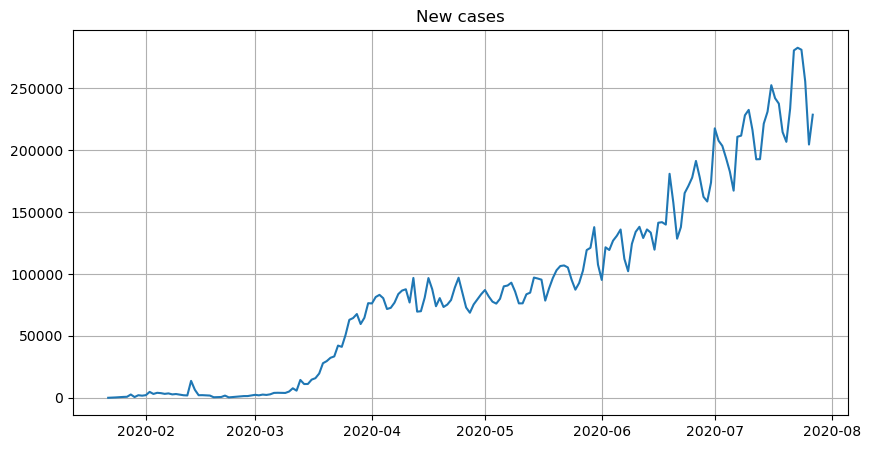

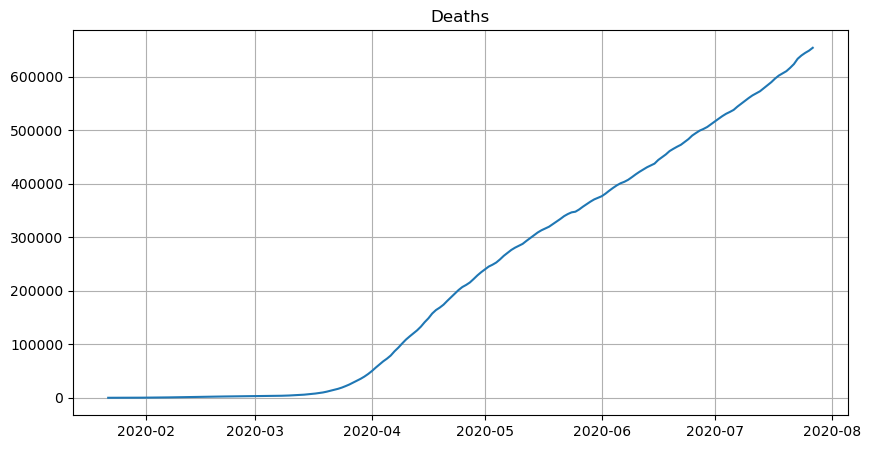

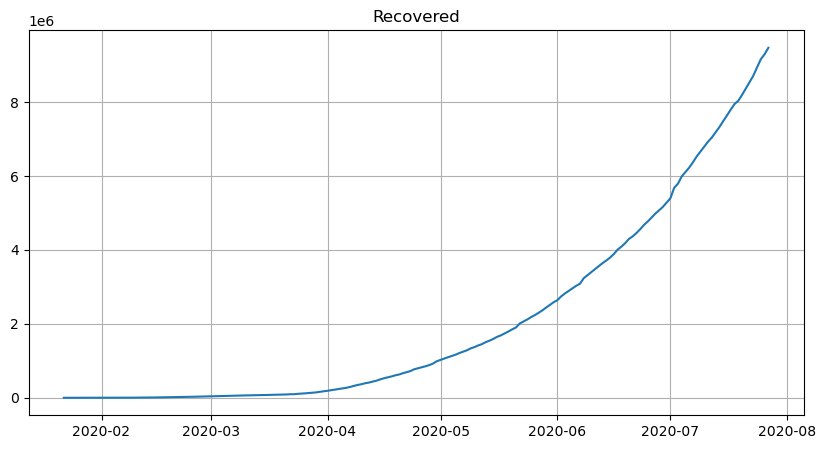

In [7]:
for col in ['New cases','Deaths','Recovered']:
    lineplot(daywise[col], title=col)

### New Cases STL Decomposition

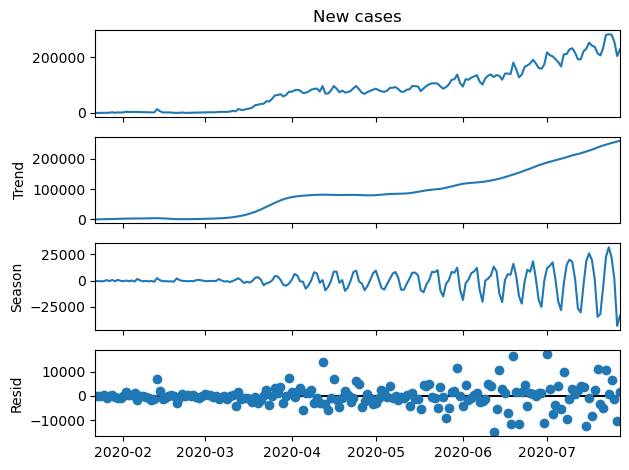

In [8]:
res = stl(daywise['New cases'])
res.plot();

## SIRD with Constant Parameters

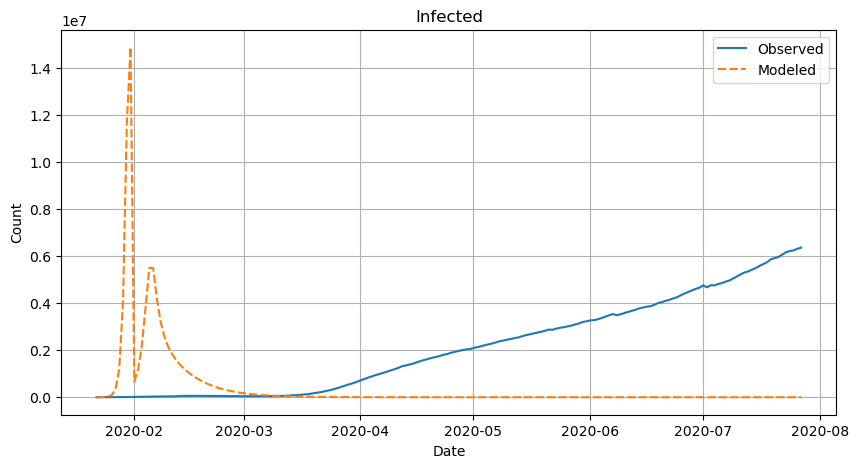

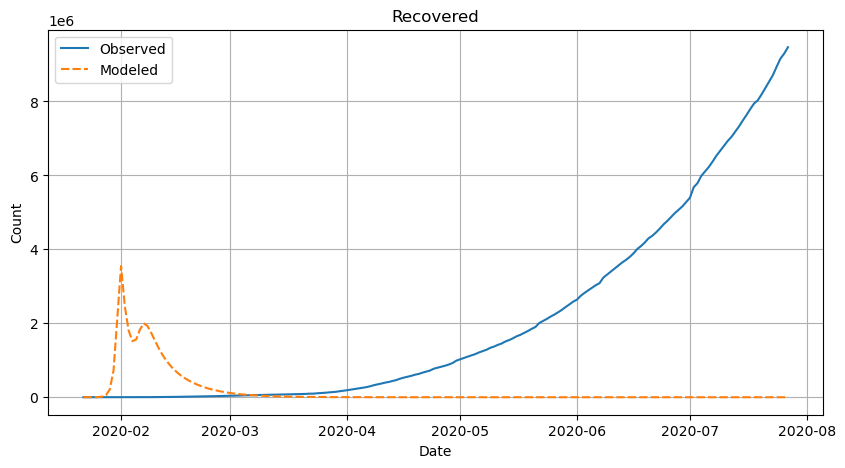

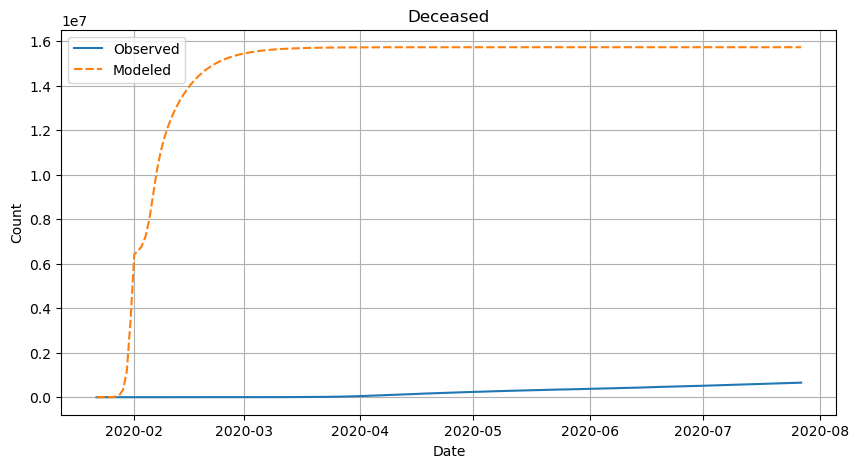

In [9]:
ALPHA, BETA, GAMMA, MU = (1/3, 3, 1/7, 1/5)

observed = daywise[['Active', 'Recovered', 'Deaths']]
i0, r0, d0 = observed.iloc[0]
s0 = 17000000
n = len(daywise)
alpha, beta, gamma, mu = np.array([(ALPHA, BETA, GAMMA, MU) for _ in range(n-1)]).T

sird = SIRD(s0, i0, r0, d0)
sird.simulate(alpha, beta, gamma, mu)
sird_df = pd.DataFrame(sird.ts, index=daywise.index)
compare(observed, sird_df[['Infected', 'Recovered', 'Deceased']])

## Dynamic Parameter Estimates

In [10]:
ALPHA = 1/90

param = pd.DataFrame({
    'beta': (daywise['Active'][1:] / daywise['Active'][:-1].values).fillna(0) - 1,
    'gamma': (daywise['New recovered'][1:] / daywise['Active'][:-1].values).fillna(0),
    'mu': (daywise['New deaths'][1:] / daywise['Active'][:-1].values).fillna(0)
})

### STL Decomposition

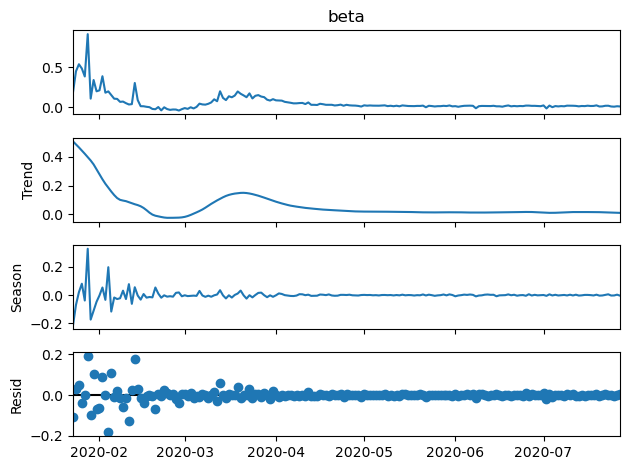

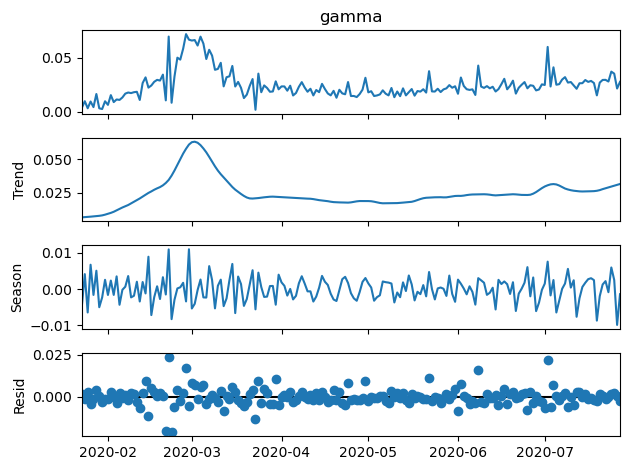

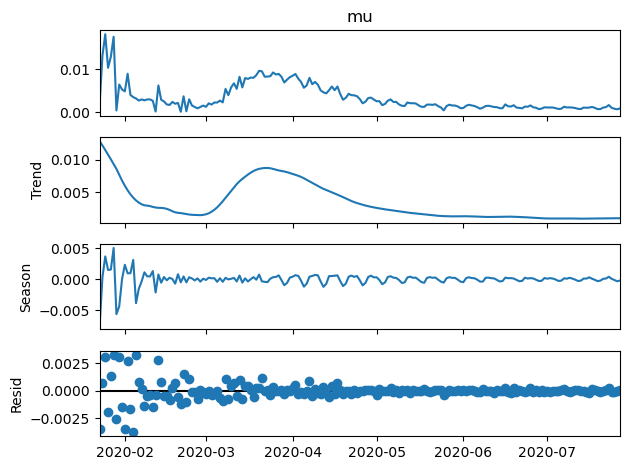

In [11]:
param_stl = param.apply(stl)
param_stl.apply(lambda x: x.plot());

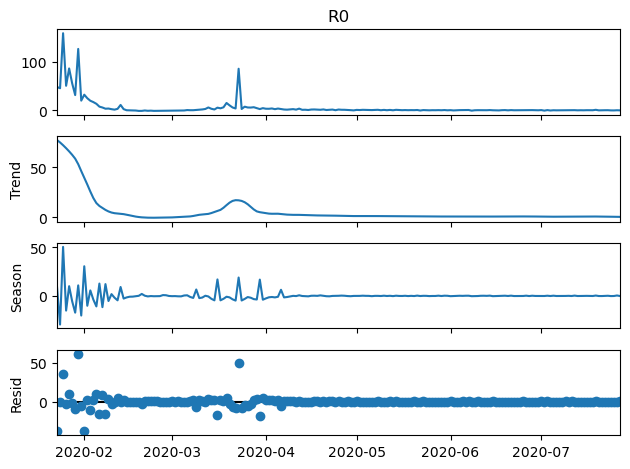

In [12]:
rO = (param['beta'] / param['gamma']).fillna(0)
rO.name = 'R0'
stl(rO).plot();

## SIRD with Dynamic Parameters

In [13]:
sird_dynamic = SIRD(s0, i0, r0, d0)
param_trends = param_stl.apply(lambda x: x.trend).T
beta, gamma, mu = [param_trends[col] for col in param_trends]
alpha = np.full_like(beta, ALPHA)
sird_dynamic.simulate(alpha, beta, gamma, mu)

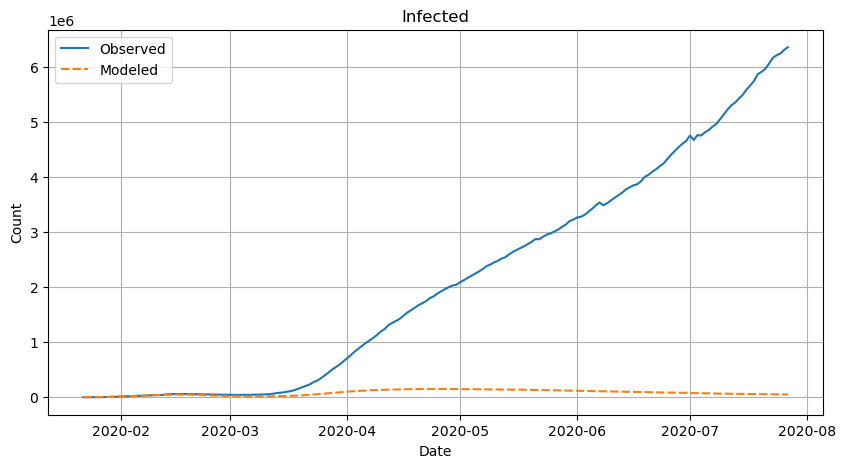

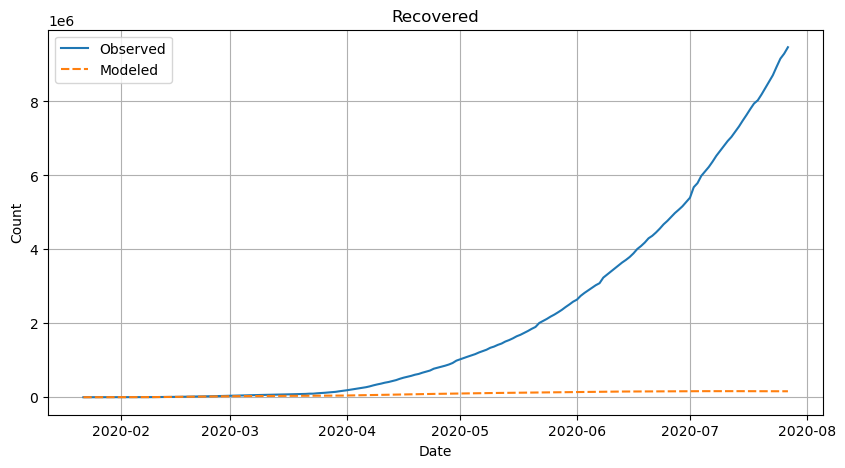

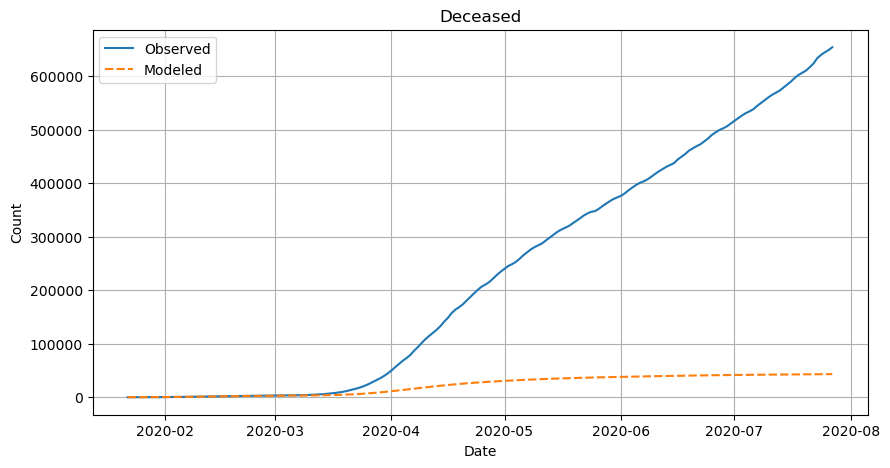

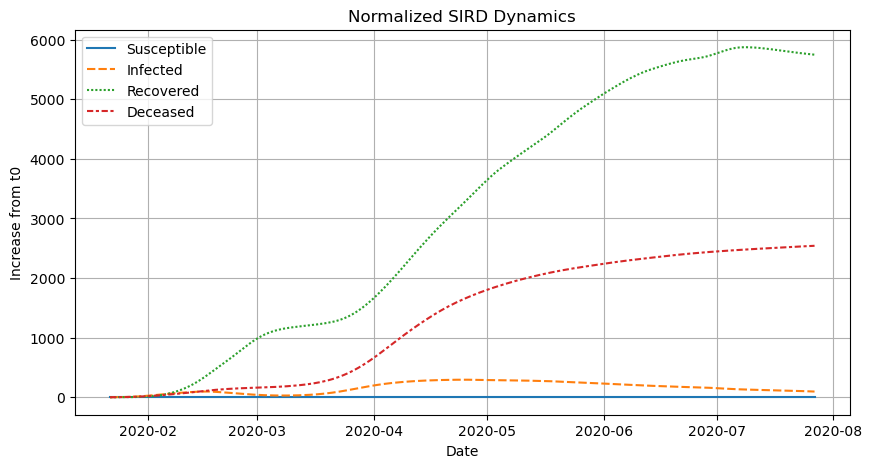

In [14]:
df = pd.DataFrame(sird_dynamic.ts, index=daywise.index)
compare(observed, df[['Infected', 'Recovered', 'Deceased']])
lineplot(df / df.iloc[0], title='Normalized SIRD Dynamics', xlabel='Date', ylabel='Increase from t0')

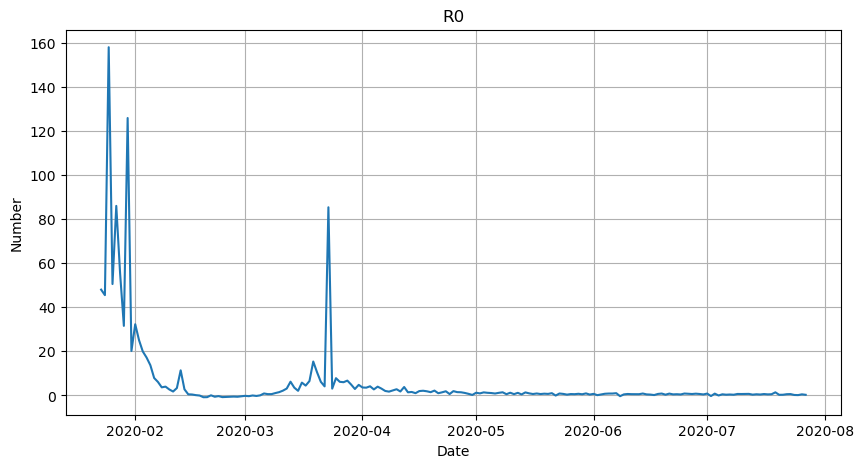

In [15]:
lineplot(rO, title='R0', xlabel='Date', ylabel='Number')

## Model Evaluation & R₀ Analysis

While the SIRD model captures the general structure of an epidemic, our dynamic simulation diverges significantly from real-world observations. Specifically:

- **Active cases** in the model peak and decline, while real data shows continued growth.
- **Recovered and deceased counts** are both underestimated by the model over time.

This discrepancy reflects real-world complexity:
- Inconsistent or delayed interventions
- Policy and behavioral shifts
- Non-homogeneous mixing (e.g. urban vs rural)
- Changing dynamics (variants, reinfections, hospital strain)

We also computed **R₀ = β / γ** dynamically. The early values are unstable due to low initial counts, but the curve stabilizes later. Notably, R₀ declines over time — possibly reflecting the impact of interventions. This aligns with the model’s behavior but not the ongoing real-world rise in cases, highlighting that:

> *Real-world transmission patterns evolved in ways the classical SIRD model does not account for.*

Thus, while useful for insight, a more complex model or real-time calibrated parameters would be needed for accurate forecasting.

# Part 3

In [16]:
covid_database = sqlite3.connect('covid_database.db')
cursor = covid_database.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print([table[0] for table in tables])

['country_wise', 'day_wise', 'usa_county_wise', 'worldometer_data']


In [17]:
pd.read_sql_query(f'SELECT * FROM worldometer_data WHERE 1=2', covid_database)

,Country.Region,Continent,Population,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Serious.Critical,Tot.Cases.1M.pop,Deaths.1M.pop,TotalTests,Tests.1M.pop,WHO.Region


In [18]:
query = """
SELECT 
    cw."Country.Region",
    cw."Active",
    cw."Deaths",
    cw."Recovered",
    wd.Population
FROM country_wise cw
JOIN worldometer_data wd
ON cw."Country.Region" = wd."Country.Region"
WHERE cw."Country.Region" = 'Italy';
"""

df_italy = pd.read_sql_query(query, covid_database)
df_italy

,Country.Region,Active,Deaths,Recovered,Population
0,Italy,12581,35112,198593,60452568


# Part 4

## Data Wrangling

In [19]:
complete = pd.read_csv('complete.csv')
complete

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO.Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,NaN,NaN,NaN,NaN,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,NaN,NaN,NaN,NaN,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,NaN,NaN,NaN,NaN,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,NaN,NaN,NaN,NaN,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,NaN,NaN,NaN,NaN,Africa
...,...,...,...,...,...,...,...,...,...,...
49251,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865.0,14.0,734.0,117.0,Africa
49252,NaN,Yemen,15.552727,48.516388,2020-07-27,1691.0,483.0,833.0,375.0,Eastern Mediterranean
49253,NaN,Comoros,-11.645500,43.333300,2020-07-27,354.0,7.0,328.0,19.0,Africa
49254,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235.0,60.0,6028.0,1147.0,Europe


Fill missing data

In [20]:
complete.fillna({
    'Province.State': 'Unknown',
    'Confirmed': 0,
    'Deaths': 0,
    'Recovered': 0,
    'Active': 0
}, inplace=True)
complete

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO.Region
0,Unknown,Afghanistan,33.939110,67.709953,2020-01-22,0.0,0.0,0.0,0.0,Eastern Mediterranean
1,Unknown,Albania,41.153300,20.168300,2020-01-22,0.0,0.0,0.0,0.0,Europe
2,Unknown,Algeria,28.033900,1.659600,2020-01-22,0.0,0.0,0.0,0.0,Africa
3,Unknown,Andorra,42.506300,1.521800,2020-01-22,0.0,0.0,0.0,0.0,Europe
4,Unknown,Angola,-11.202700,17.873900,2020-01-22,0.0,0.0,0.0,0.0,Africa
...,...,...,...,...,...,...,...,...,...,...
49251,Unknown,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865.0,14.0,734.0,117.0,Africa
49252,Unknown,Yemen,15.552727,48.516388,2020-07-27,1691.0,483.0,833.0,375.0,Eastern Mediterranean
49253,Unknown,Comoros,-11.645500,43.333300,2020-07-27,354.0,7.0,328.0,19.0,Africa
49254,Unknown,Tajikistan,38.861000,71.276100,2020-07-27,7235.0,60.0,6028.0,1147.0,Europe


Drop duplicates

In [21]:
duplicates = complete.duplicated()
print(f"Duplicate rows: {duplicates.sum()}")
complete.drop_duplicates(inplace=True)

Duplicate rows: 188


Check datatypes

In [22]:
print(complete.dtypes)

Province.State     object
Country.Region     object
Lat               float64
Long              float64
Date               object
Confirmed         float64
Deaths            float64
Recovered         float64
Active            float64
WHO.Region         object
dtype: object


Fix 'Date' datatype

In [23]:
complete['Date'] = pd.to_datetime(complete['Date'])
print(complete.dtypes)

Province.State            object
Country.Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                float64
Deaths                   float64
Recovered                float64
Active                   float64
WHO.Region                object
dtype: object


In [24]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49068 entries, 0 to 49255
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province.State  49068 non-null  object        
 1   Country.Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  float64       
 6   Deaths          49068 non-null  float64       
 7   Recovered       49068 non-null  float64       
 8   Active          49068 non-null  float64       
 9   WHO.Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 4.1+ MB


## Observations

In [25]:
GAMMA = 1/4.5

country = 'Italy'

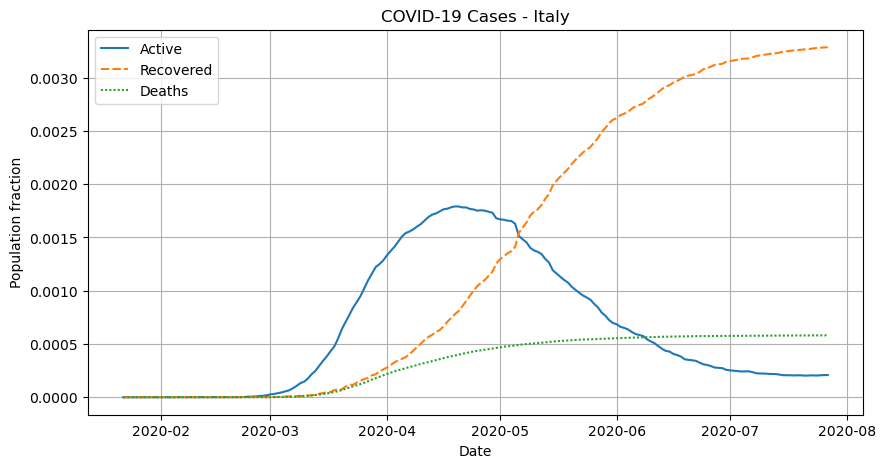

In [26]:
def plot_cases(df, country):
    daywise = df[df['Country.Region'] == country][['Date','Active','Recovered','Deaths']]\
                .set_index('Date')
    population = pd.read_sql_query(f"""
                                    SELECT Population FROM worldometer_data
                                    WHERE "Country.Region" = '{country}';
                                    """, covid_database).iloc[0, 0]
    lineplot(daywise / population, title=f'COVID-19 Cases - {country}', xlabel='Date', ylabel='Population fraction')


plot_cases(complete, country)

## Parameter Estimation

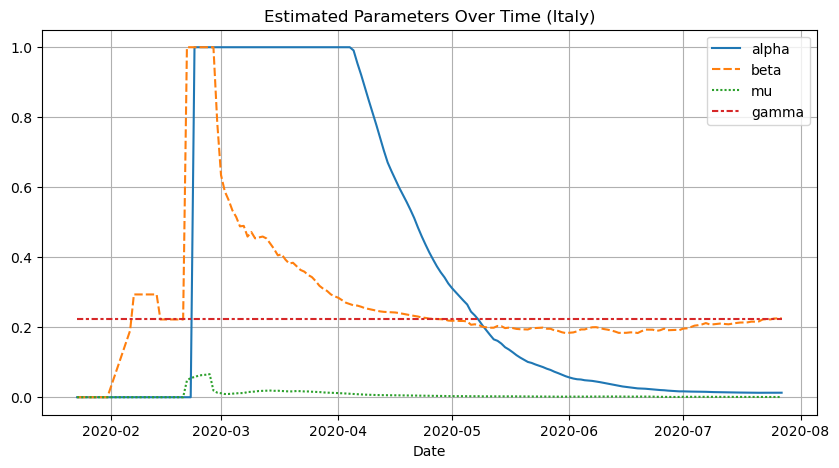

In [27]:
def estimate_params(df, gamma, country):
    # Extract and index
    daywise = df[df['Country.Region'] == country][['Date','Active','Recovered','Deaths']]\
                .set_index('Date').copy()
    daywise = daywise.sort_index()
    
    # Population from worldometer
    population = pd.read_sql_query(f"""
        SELECT Population FROM worldometer_data
        WHERE "Country.Region" = '{country}';
    """, covid_database).iloc[0, 0]

    # Differentials
    delta_I = daywise['Active'].diff()[1:]
    delta_D = daywise['Deaths'].diff()[1:]
    delta_R = daywise['Recovered'].diff()[1:]
    
    # Time-aligned data (drop first row to match diffed values)
    infected = daywise['Active'][:-1].values
    recovered = daywise['Recovered'][:-1].values
    deaths = daywise['Deaths'][:-1].values
    susceptible = population - infected - recovered - deaths
    
    # Estimate parameters
    mu = (delta_D / infected).replace([np.inf, -np.inf], 0).fillna(0)
    alpha = ((gamma * infected - delta_R) / recovered).replace([np.inf, -np.inf], 0).fillna(0)
    beta_num = delta_I + mu * infected + gamma * infected
    beta_den = (susceptible * infected) / population
    beta = (beta_num / beta_den).replace([np.inf, -np.inf], 0).fillna(0)

    params = pd.DataFrame({
        'alpha': alpha,
        'beta': beta,
        'mu': mu
    })
    params['gamma'] = gamma
    params = params.rolling(7, min_periods=1).mean().clip(lower=0, upper=1)\
                .dropna().astype(float)
    return params

params_italy = estimate_params(complete, GAMMA, country)
lineplot(params_italy, title=f'Estimated Parameters Over Time ({country})', xlabel='Date', ylabel=None)

## SIRD-Model

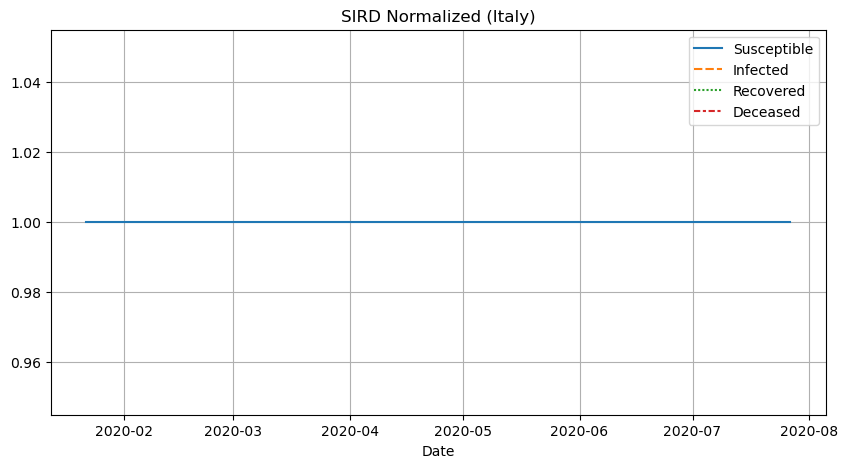

In [28]:
def sird_model(df, gamma, country):
    daywise = df[df['Country.Region'] == country][['Date','Active','Recovered','Deaths']]\
                .set_index('Date').copy()
    daywise = daywise.sort_index()
    population = pd.read_sql_query(f"""
                                    SELECT Population FROM worldometer_data
                                    WHERE "Country.Region" = '{country}';
                                    """, covid_database).iloc[0, 0]
    i0, r0, d0 = daywise[['Active','Recovered','Deaths']].iloc[0]
    s0 = population - i0 - r0 - d0
    sird = SIRD(s0, i0, r0, d0)
    params = estimate_params(df, gamma, country)
    sird.simulate(alpha=params['alpha'], beta=params['beta'], gamma=params['gamma'], mu=params['mu'])
    return pd.DataFrame(sird.ts, index=daywise.index)

sird_df = sird_model(complete, GAMMA, country)
lineplot(sird_df / sird_df.max(), title=f'SIRD Normalized ({country})', xlabel='Date', ylabel=None)

## R0

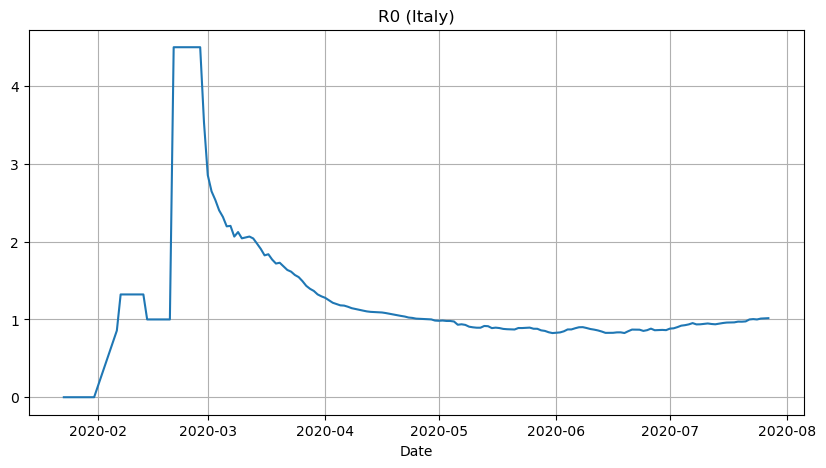

In [32]:
def r0_ts(df, gamma, country):
    params = estimate_params(df, gamma, country)
    r0 = params['beta'] / params['gamma']
    return r0

r0 = r0_ts(complete, GAMMA, country)
lineplot(r0, title=f'R0 ({country})', xlabel='Date')